In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm.notebook import tqdm

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = 'cpu'

In [3]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

In [4]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    if isinstance(state, tuple):
        state = state[0]
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [5]:
#Make environment
env = gym.make('CartPole-v1')

#Init network
network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-2)

In [6]:
state = env.reset()
select_action(network, state)

(0, tensor([-0.6856], device='cuda:0', grad_fn=<SqueezeBackward1>))

In [7]:
#track scores
scores = []

#iterate through episodes
for episode in tqdm(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    rewards = []
    log_probs = []
    score = 0
    
    #generate episode
    for step in range(MAX_STEPS):
        env.render()
        
        #select action
        action, lp = select_action(network, state)
        
        #execute action
        new_state, reward, done, _, _ = env.step(action)
        
        #track episode score
        score += reward
        
        #store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)
        
        #end episode
        if done:
            break
        
        #move into new state
        state = new_state
    
    #append score
    scores.append(score)
        
    #Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []
    
    #track cumulative reward
    total_r = 0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r ** DISCOUNT_FACTOR
        
        #append to discounted rewards
        discounted_rewards.append(total_r)
    
    #reverse discounted rewards
    rewards = torch.tensor(discounted_rewards).to(DEVICE)
    rewards = torch.flip(rewards, [0])
    
    #adjusting policy parameters with gradient ascent
    loss = []
    for r, lp in zip(rewards, log_probs):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * lp)
    
        
    #Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

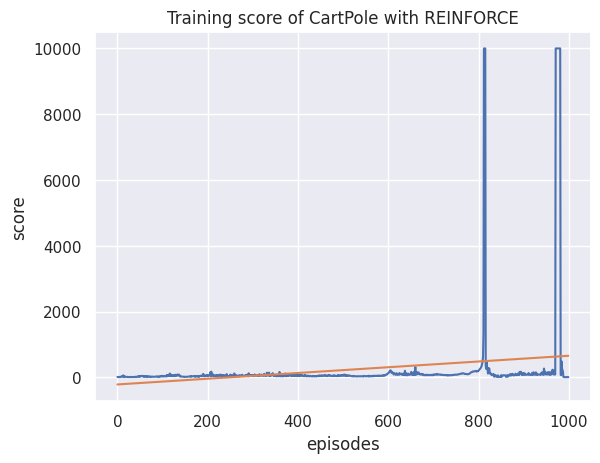

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [9]:
done = False
state = env.reset()
scores = []

for _ in range(10):
    state = env.reset()
    done = False
    score = 0
    while not done:
        # env.render()
        action = env.action_space.sample()
        new_state, reward, done, info, _ = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

In [10]:
done = False
state = env.reset()
scores = []

for _ in tqdm(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action, lp = select_action(network, state)
        new_state, reward, done, info, _ = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
np.array(scores).mean()

9.28